### The assignment
Forecasting predicts the number of sales in the future. Having the right amount of products in stock is a core challenge in retail. A good forecast makes sure there are enough of your favourite products in stock, even if you come to the store late in the evening.

In this project, you will use a subset of M5 Forecasting - Accuracy hierarchical sales data from Walmart at one store, TX3 in the State of Texas, the world’s largest company by revenue, to forecast daily sales for the next 28 days. The data include item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Altogether, it can be used to improve forecasting accuracy. 

In [1]:
# Load necessary libraries
library(tidyverse)
library(data.table)
library(lubridate)

Warning message:
"package 'tidyverse' was built under R version 4.1.3"
Warning message:
"package 'tibble' was built under R version 4.1.3"
Warning message:
"package 'tidyr' was built under R version 4.1.3"
Warning message:
"package 'readr' was built under R version 4.1.3"
Warning message:
"package 'purrr' was built under R version 4.1.3"
Warning message:
"package 'dplyr' was built under R version 4.1.3"
Warning message:
"package 'forcats' was built under R version 4.1.3"
Warning message:
"package 'lubridate' was built under R version 4.1.3"
-- Attaching core tidyverse packages ---------------------------------------------------------------- tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.1     
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stat

### Loading & inspecting the files

In [2]:
# Csv files
calendar <- fread("calendar_afcs2024.csv")
sell_prices <- fread("sell_prices_afcs2024.csv")
sales_train <- fread("sales_train_validation_afcs2024.csv")
sales_test <- fread("sales_test_validation_afcs2024.csv")
sample_submission <- fread("sample_submission_afcs2024.csv")
sales_test_evaluation <- fread("sales_test_evaluation_afcs_2024.csv")

In [3]:
head(calendar)

date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX
<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>
1/29/2011,11101,Saturday,1,1,2011,NA,NA,NA,NA,0
1/30/2011,11101,Sunday,2,1,2011,NA,NA,NA,NA,0
1/31/2011,11101,Monday,3,1,2011,NA,NA,NA,NA,0
2/1/2011,11101,Tuesday,4,2,2011,NA,NA,NA,NA,1
2/2/2011,11101,Wednesday,5,2,2011,NA,NA,NA,NA,0
2/3/2011,11101,Thursday,6,2,2011,NA,NA,NA,NA,1


In [4]:
head(sell_prices)

store_id,item_id,wm_yr_wk,sell_price
<chr>,<chr>,<int>,<dbl>
TX_3,FOODS_3_001,11101,2.28
TX_3,FOODS_3_001,11102,2.28
TX_3,FOODS_3_001,11103,2.28
TX_3,FOODS_3_001,11104,2.28
TX_3,FOODS_3_001,11105,2.28
TX_3,FOODS_3_001,11106,2.28


In [5]:
head(sales_train) # sales test and test_evaluation have the same structure, it's just a different subset of d_is

id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
FOODS_3_001_TX_3_validation,0,2,1,3,0,0,1,0,2,...,0,0,0,0,2,0,0,5,2,0
FOODS_3_002_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FOODS_3_003_TX_3_validation,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0
FOODS_3_004_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
FOODS_3_005_TX_3_validation,0,1,1,0,0,1,2,0,0,...,0,4,2,1,1,0,1,0,4,0
FOODS_3_006_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,2,1,0,0,1,1,1,0


In [6]:
head(sample_submission)

id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
FOODS_3_001_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FOODS_3_002_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FOODS_3_003_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FOODS_3_004_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FOODS_3_005_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FOODS_3_006_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Handling missing values in calendar and sell prices

In [7]:
# Number of missing values
colSums(is.na(calendar)) 
colSums(is.na(sell_prices)) 

date     wm_yr_wk      weekday         wday        month         year 
           0            0            0            0            0            0 
event_name_1 event_type_1 event_name_2 event_type_2      snap_TX 
        1807         1807         1964         1964            0

store_id    item_id   wm_yr_wk sell_price 
         0          0          0          0

The columns related to events (event_name_1, event_type_1, etc.) have many missing values (NA).
No imputation is necessary as these events are 'missing by design,' which means that they are intentionally left blank to indicate that there were no special events on those days.
     

### Merging datasets

In [14]:
# sales_train data as a data.table
sales_train <- as.data.table(sales_train)
    
# Extracting the item_id from the id column in sales_train in order to match it with sell_prices dataset
sales_train_long <- sales_train[, c(
  .SD,  # This keeps all existing columns in the data.table
  .(
    item_id = paste(tstrsplit(id, "_", fixed = TRUE)[[1]], 
                    tstrsplit(id, "_", fixed = TRUE)[[2]], 
                    tstrsplit(id, "_", fixed = TRUE)[[3]], sep = "_")
  )
), by = .(id)]

In [15]:
head(sales_train_long)

id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,item_id
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
FOODS_3_001_TX_3_validation,0,2,1,3,0,0,1,0,2,...,0,0,0,2,0,0,5,2,0,FOODS_3_001
FOODS_3_002_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,FOODS_3_002
FOODS_3_003_TX_3_validation,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,FOODS_3_003
FOODS_3_004_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,FOODS_3_004
FOODS_3_005_TX_3_validation,0,1,1,0,0,1,2,0,0,...,4,2,1,1,0,1,0,4,0,FOODS_3_005
FOODS_3_006_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,2,1,0,0,1,1,1,0,FOODS_3_006


In [16]:
sell_prices <- as.data.table(sell_prices)
sales_prices <- merge(sales_train_long, sell_prices, by = c("item_id"), all.x = TRUE)

In [25]:
head(sales_prices)

item_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,store_id,wm_yr_wk,sell_price
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<dbl>
FOODS_3_001,0,2,1,3,0,0,1,0,2,...,0,2,0,0,5,2,0,TX_3,11101,2.28
FOODS_3_001,0,2,1,3,0,0,1,0,2,...,0,2,0,0,5,2,0,TX_3,11102,2.28
FOODS_3_001,0,2,1,3,0,0,1,0,2,...,0,2,0,0,5,2,0,TX_3,11103,2.28
FOODS_3_001,0,2,1,3,0,0,1,0,2,...,0,2,0,0,5,2,0,TX_3,11104,2.28
FOODS_3_001,0,2,1,3,0,0,1,0,2,...,0,2,0,0,5,2,0,TX_3,11105,2.28
FOODS_3_001,0,2,1,3,0,0,1,0,2,...,0,2,0,0,5,2,0,TX_3,11106,2.28


In [20]:
sales_prices[, id := NULL]  # Removes the 'id' column in-place
head(sales_prices)

item_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,store_id,wm_yr_wk,sell_price
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<dbl>
FOODS_3_001,0,2,1,3,0,0,1,0,2,...,0,2,0,0,5,2,0,TX_3,11101,2.28
FOODS_3_001,0,2,1,3,0,0,1,0,2,...,0,2,0,0,5,2,0,TX_3,11102,2.28
FOODS_3_001,0,2,1,3,0,0,1,0,2,...,0,2,0,0,5,2,0,TX_3,11103,2.28
FOODS_3_001,0,2,1,3,0,0,1,0,2,...,0,2,0,0,5,2,0,TX_3,11104,2.28
FOODS_3_001,0,2,1,3,0,0,1,0,2,...,0,2,0,0,5,2,0,TX_3,11105,2.28
FOODS_3_001,0,2,1,3,0,0,1,0,2,...,0,2,0,0,5,2,0,TX_3,11106,2.28


In [24]:
# Obtained a duplicates error so decided to remove them
calendar <- unique(calendar, by = "wm_yr_wk")

# Merging with calendar now
merged_data <- merge(sales_prices, calendar, by = "wm_yr_wk", all.x = TRUE)
head(merged_data)

wm_yr_wk,item_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,date,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX
<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>
11101,FOODS_3_001,0,2,1,3,0,0,1,0,...,1/29/2011,Saturday,1,1,2011,NA,NA,NA,NA,0
11101,FOODS_3_005,0,1,1,0,0,1,2,0,...,1/29/2011,Saturday,1,1,2011,NA,NA,NA,NA,0
11101,FOODS_3_007,27,27,8,0,0,11,8,33,...,1/29/2011,Saturday,1,1,2011,NA,NA,NA,NA,0
11101,FOODS_3_011,1,2,3,3,1,1,3,7,...,1/29/2011,Saturday,1,1,2011,NA,NA,NA,NA,0
11101,FOODS_3_014,3,3,2,4,1,1,2,0,...,1/29/2011,Saturday,1,1,2011,NA,NA,NA,NA,0
11101,FOODS_3_017,0,0,0,0,1,0,0,0,...,1/29/2011,Saturday,1,1,2011,NA,NA,NA,NA,0


In [22]:
# Checking the number of items we have
unique_item_count <- uniqueN(sell_prices$item_id)
unique_item_count

[1] 823

## Our EDA will focus on inspecting on whether the price changes on our 823 items are correlated with events 

In [33]:
table(merged_data$event_name_1)
table(merged_data$event_type_1)


    Cinco De Mayo       Eid al-Fitr         EidAlAdha         Halloween 
              526               820               793               823 
  IndependenceDay OrthodoxChristmas        Pesach End     StPatricksDay 
              820               473              2157               508 
    ValentinesDay 
              817 


 Cultural  National Religious 
     2674       820      4243 

In [35]:
table(merged_data$event_name_2)
table(merged_data$event_type_2)

# maybe deleted some when removing the duplicates or too many NaNs?

< table of extent 0 >

< table of extent 0 >

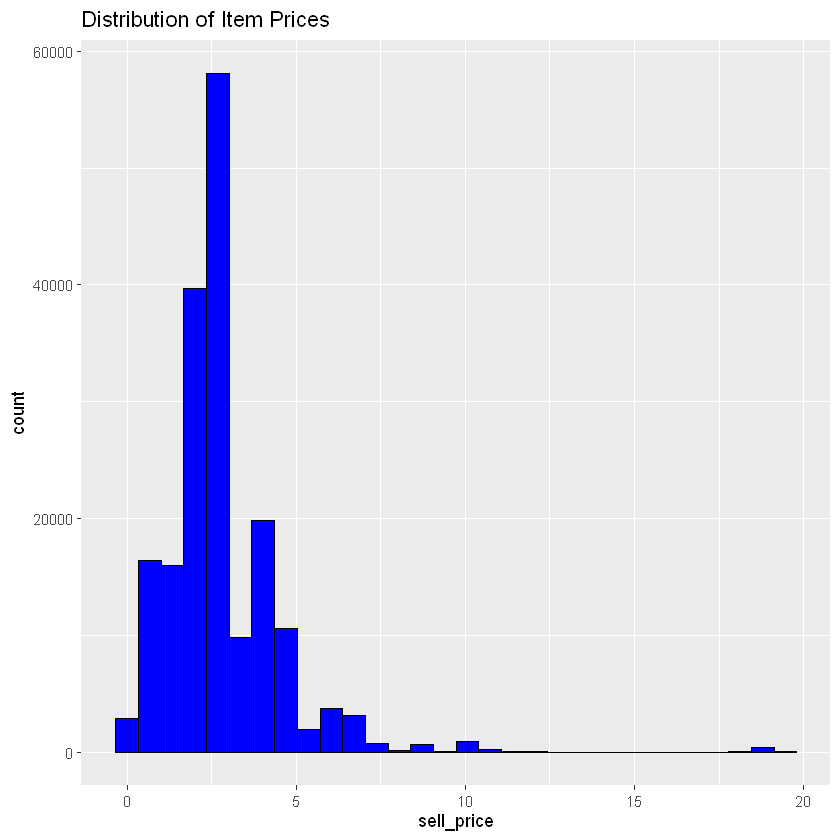

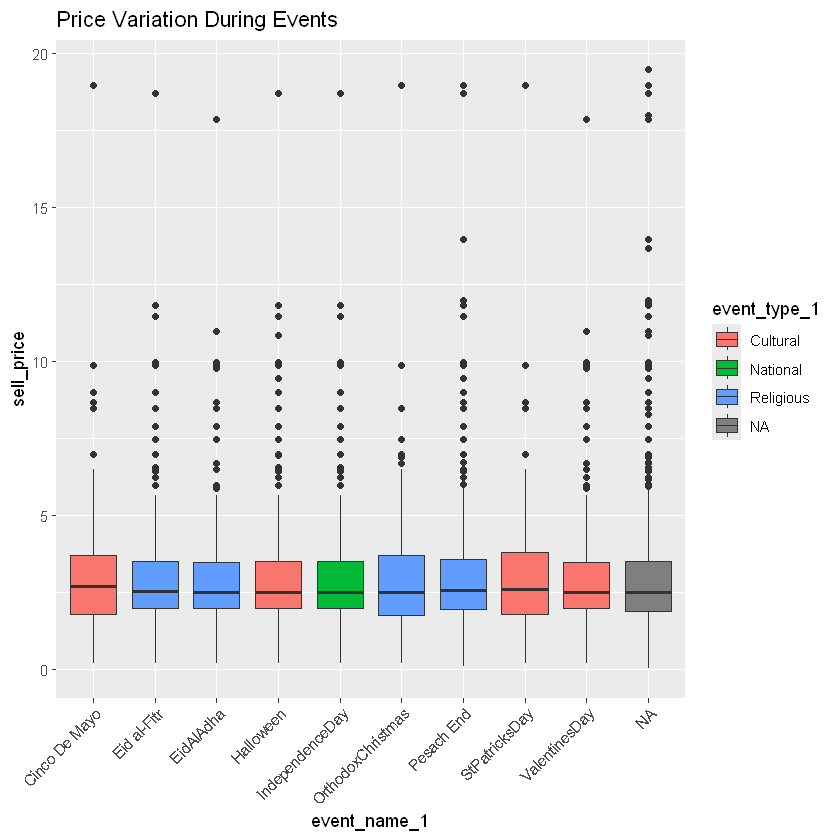

In [32]:
library(ggplot2)

# Histogram of prices
ggplot(merged_data, aes(x = sell_price)) +
  geom_histogram(bins = 30, fill = "blue", color = "black") +
  ggtitle("Distribution of Item Prices")

# Boxplot to see price variations during events
ggplot(merged_data, aes(x = event_name_1, y = sell_price, fill = event_type_1)) +
  geom_boxplot() +
  ggtitle("Price Variation During Events") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))